# Implementing the linear regression method in TensorFlow 2

### Import the required modules

In [1]:
%%time
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks


from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
print(tf.__version__)

2023-05-06 19:26:51.394986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tumbarell/apertium/lib::/usr/local/lib/root:/usr/local/lib/root/python:/usr/local/include/root:/usr/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/home/tumbarell/revtex4-2-tds
2023-05-06 19:26:51.395022: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0
CPU times: user 5.69 s, sys: 642 ms, total: 6.33 s
Wall time: 7.77 s


### Load and configure the Boston housing data set

In [2]:
boston_load = datasets.load_boston()
print(type(boston_load))
feature_columns = boston_load.feature_names
target_column = boston_load.target
boston_data = pd.DataFrame(boston_load.data,columns=feature_columns).astype(np.float32)
boston_data['MEDV'] = target_column.astype(np.float32)
boston_data.head()

/home/tumbarell/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

<class 'sklearn.utils.Bunch'>


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.199997,4.0900,1.0,296.0,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900002,4.9671,2.0,242.0,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.099998,4.9671,2.0,242.0,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.799999,6.0622,3.0,222.0,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200001,6.0622,3.0,222.0,18.700001,396.899994,5.33,36.200001


### Check the relation between the variables, using pairplot and a correlation graph.

CPU times: user 35.3 s, sys: 555 ms, total: 35.9 s
Wall time: 35.7 s


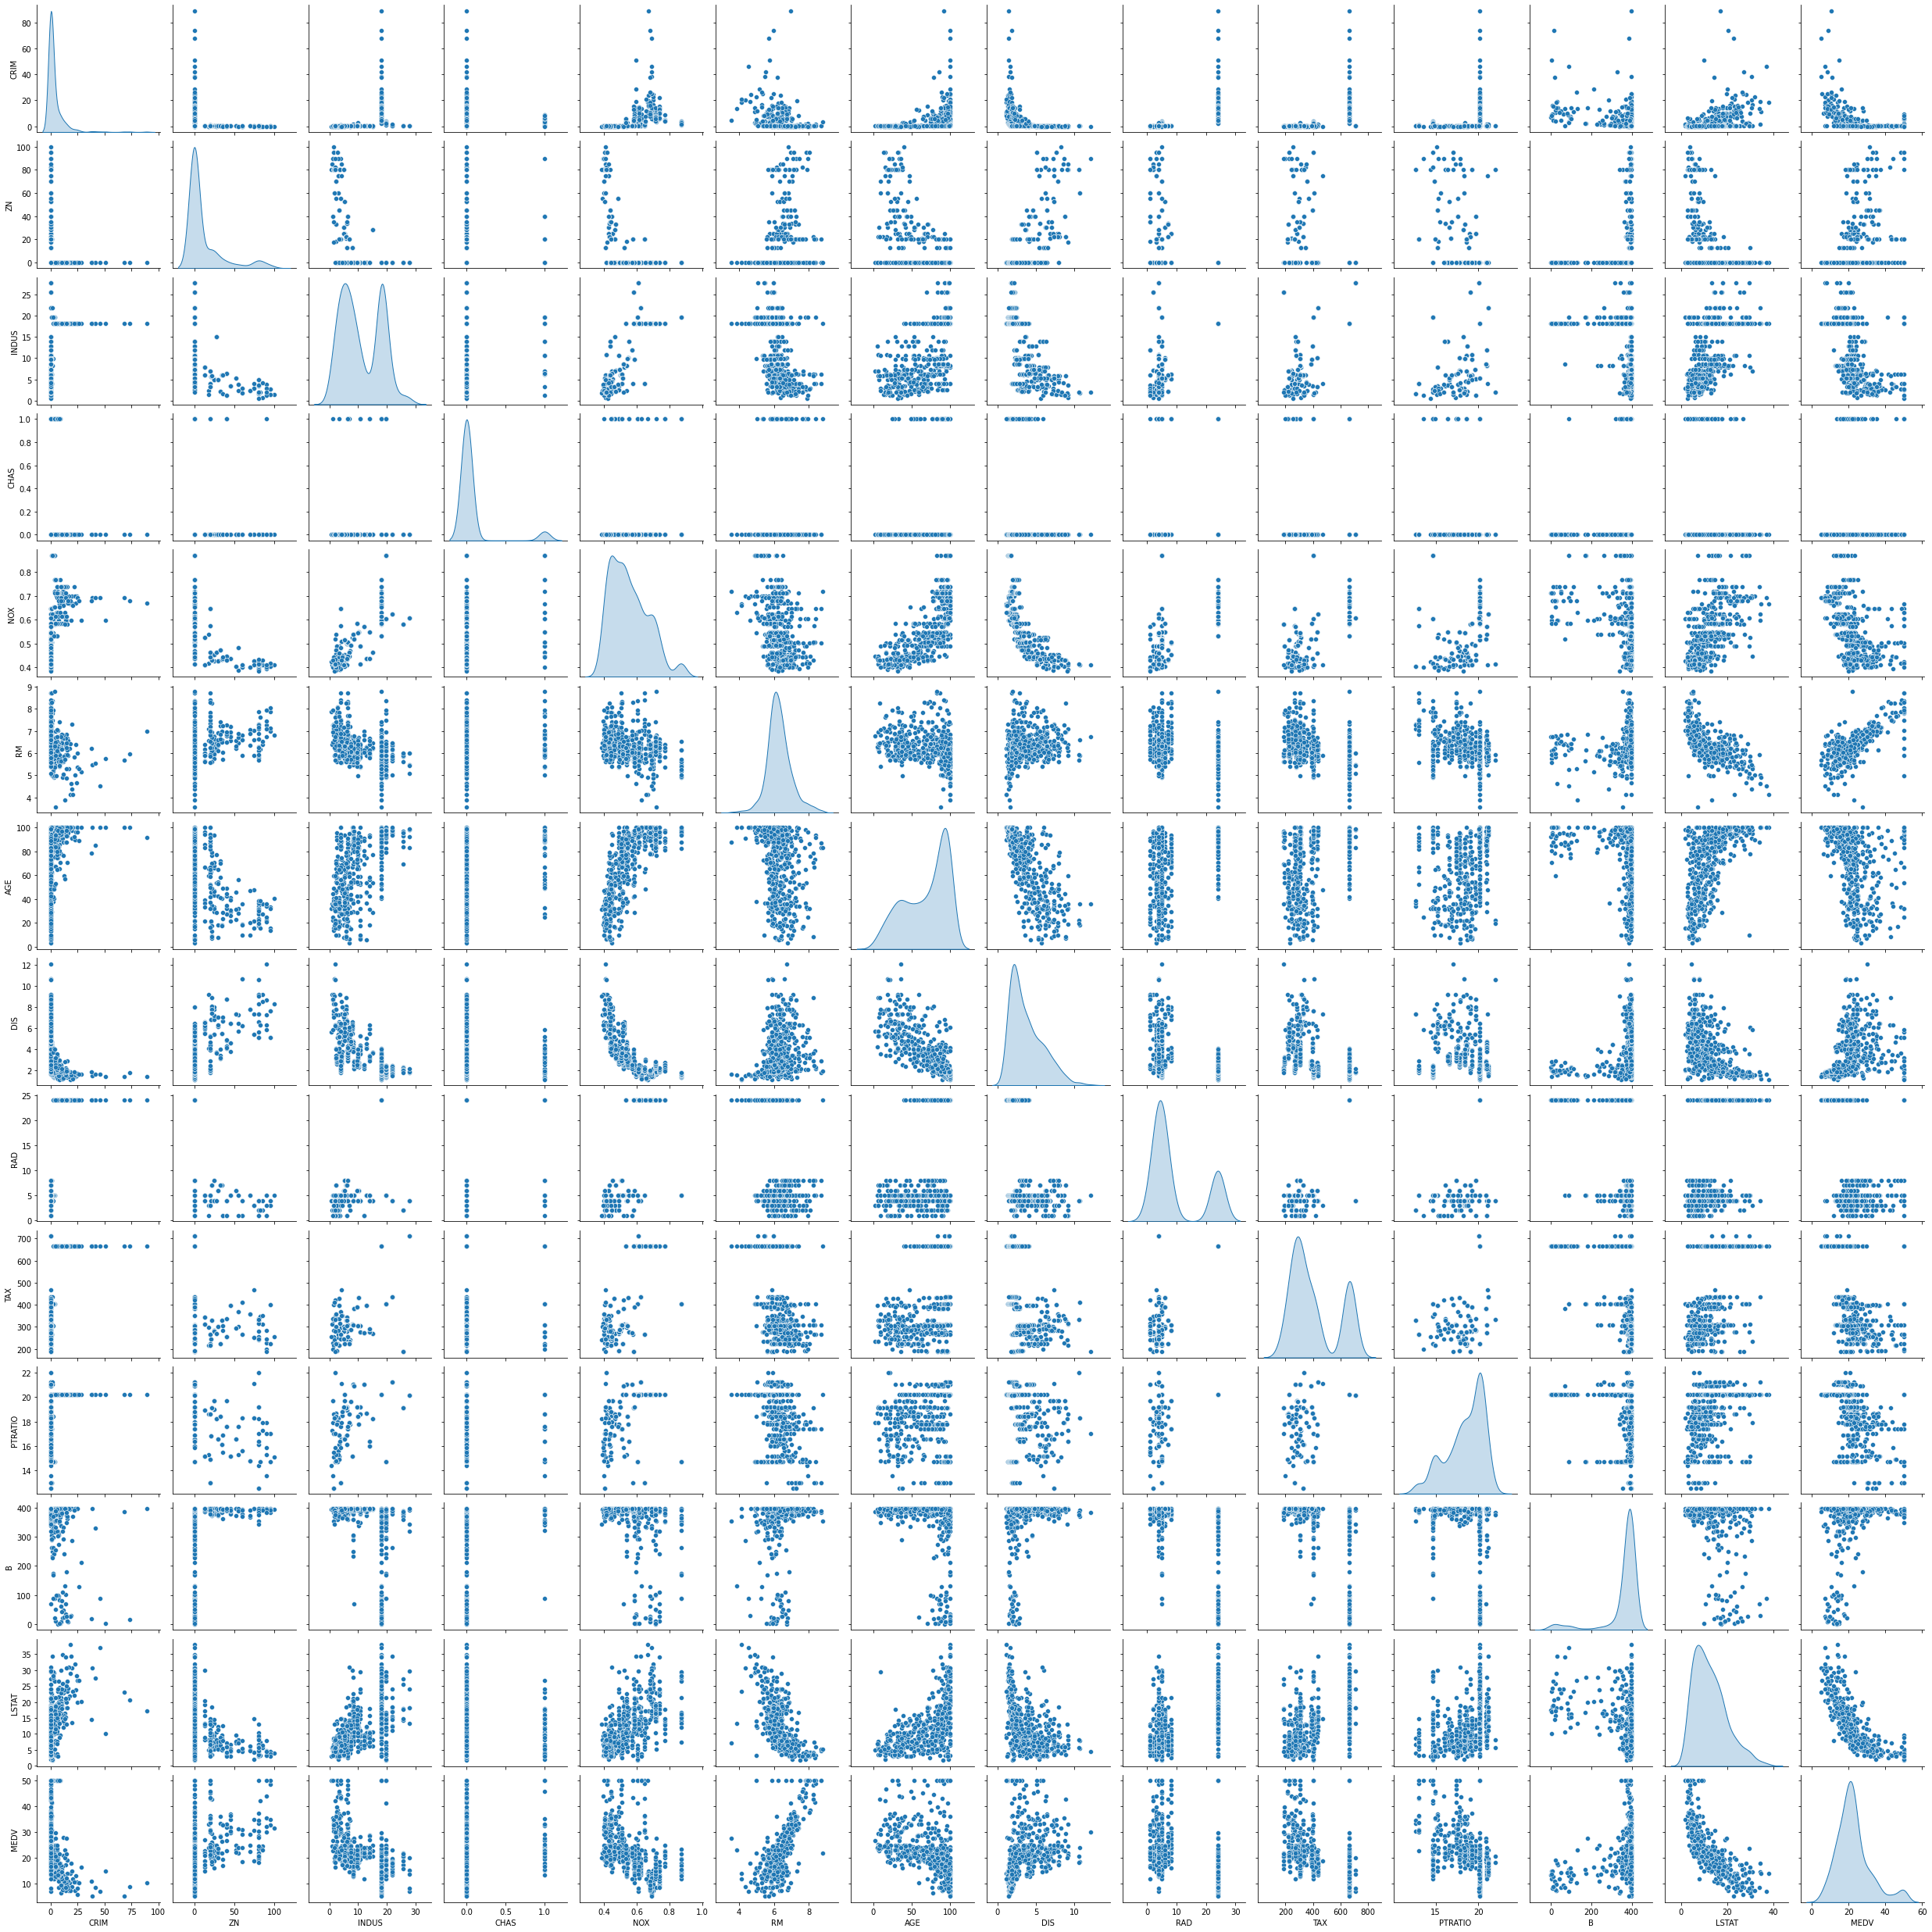

In [4]:
%%time
sb.pairplot(boston_data, diag_kind="kde")

In [5]:
%%time
correlation_data = boston_data.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

CPU times: user 147 ms, sys: 12.1 ms, total: 160 ms
Wall time: 489 ms


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355502,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


### Descriptive statistics—central tendency and dispersion

In [6]:
%%time
stats = boston_data.describe()
boston_stats = stats.transpose()
boston_stats

CPU times: user 65.1 ms, sys: 22 µs, total: 65.2 ms
Wall time: 64.3 ms


,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613523,8.601545,0.00632,0.082045,0.256510,3.677083,88.976196
ZN,506.0,11.363636,23.322390,0.00000,0.000000,0.000000,12.500000,100.000000
INDUS,506.0,11.136797,6.860355,0.46000,5.190000,9.690000,18.100000,27.740000
CHAS,506.0,0.069170,0.253993,0.00000,0.000000,0.000000,0.000000,1.000000
NOX,506.0,0.554696,0.115878,0.38500,0.449000,0.538000,0.624000,0.871000
RM,506.0,6.284636,0.702617,3.56100,5.885500,6.208500,6.623500,8.780000
AGE,506.0,68.574921,28.148869,2.90000,45.025000,77.500000,94.074999,100.000000
DIS,506.0,3.795043,2.105711,1.12960,2.100175,3.207450,5.188425,12.126500
RAD,506.0,9.549407,8.707269,1.00000,4.000000,5.000000,24.000000,24.000000
TAX,506.0,408.237152,168.537170,187.00000,279.000000,330.000000,666.000000,711.000000


### Selecting columns and splitting the data

In [8]:
%%time

X_data = boston_data[[i for i in boston_data.columns if i not in ['MEDV']]]
Y_data = boston_data[['MEDV']]

training_features , test_features ,training_labels, test_labels = train_test_split(X_data , Y_data , test_size=0.2)

print('No. of rows in Training Features: ', training_features.shape[0])
print('No. of rows in Test Features: ', test_features.shape[0])
print('No. of columns in Training Features: ', training_features.shape[1])
print('No. of columns in Test Features: ', test_features.shape[1])
print('No. of rows in Training Label: ', training_labels.shape[0])
print('No. of rows in Test Label: ', test_labels.shape[0])
print('No. of columns in Training Label: ', training_labels.shape[1])
print('No. of columns in Test Label: ', test_labels.shape[1])

No. of rows in Training Features:  404
No. of rows in Test Features:  102
No. of columns in Training Features:  13
No. of columns in Test Features:  13
No. of rows in Training Label:  404
No. of rows in Test Label:  102
No. of columns in Training Label:  1
No. of columns in Test Label:  1
CPU times: user 5.96 ms, sys: 0 ns, total: 5.96 ms
Wall time: 5.96 ms


### Normalizing the data

In [9]:
%%time

def norm(x):
    stats = x.describe()
    stats = stats.transpose()
    return (x - stats['mean']) / stats['std']

normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

CPU times: user 121 ms, sys: 9 µs, total: 121 ms
Wall time: 123 ms


### Build the input pipeline for the tensorflow model

In [10]:
%%time

def feed_input(features_dataframe, target_dataframe,num_of_epochs=10, shuffle=True, batch_size=32):
    def input_feed_function():
        dataset = tf.data.Dataset.from_tensor_slices((dict(features_dataframe), target_dataframe))
        if shuffle:
            dataset = dataset.shuffle(2000)
        dataset = dataset.batch(batch_size).repeat(num_of_epochs)
        return dataset
    return input_feed_function

train_feed_input = feed_input(normed_train_features,training_labels)
train_feed_input_testing = feed_input(normed_train_features,training_labels, num_of_epochs=1, shuffle=False)
test_feed_input = feed_input(normed_test_features,test_labels, num_of_epochs=1, shuffle=False)

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 16.7 µs


### Model training

In [11]:
%%time

feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]
linear_model = LinearRegressor(feature_columns=feature_columns_numeric, optimizer='RMSProp')
linear_model.train(train_feed_input)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmph3sfubt8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

2023-05-06 23:53:42.928141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tumbarell/apertium/lib::/usr/local/lib/root:/usr/local/lib/root/python:/usr/local/include/root:/usr/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/home/tumbarell/revtex4-2-tds
2023-05-06 23:53:42.928178: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-06 23:53:42.928209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tumbarell-X55C): /proc/driver/nvidia/version does not exist
/home/tumbarell/anaconda3/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmph3sfubt8/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 582.20154, step = 0
INFO:tensorflow:global_step/sec: 196.412
INFO:tensorflow:loss = 44.20382, step = 100 (0.512 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130...
INFO:tensorflow:Saving checkpoints for 130 into /tmp/tmph3sfubt8/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130...
INFO:tensorflow:Loss for final step: 19.038849.
CPU times: user 5.13 s, sys: 68.8 ms, total: 5.2 s
Wall time: 5.18 s


### Predictions

In [12]:
%%time

train_predictions = linear_model.predict(train_feed_input_testing)
test_predictions = linear_model.predict(test_feed_input)
train_predictions_series = pd.Series([p['predictions'][0] for p in train_predictions])
test_predictions_series = pd.Series([p['predictions'][0] for p in test_predictions])

INFO:tensorflow:Calling model_fn.


/home/tumbarell/anaconda3/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmph3sfubt8/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.


/home/tumbarell/anaconda3/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmph3sfubt8/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
CPU times: user 2.6 s, sys: 36.2 ms, total: 2.63 s
Wall time: 2.66 s


In [13]:
%%time

train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])
training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)
train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels,test_predictions_df], axis=1)

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 27.2 ms


### Validation

In [14]:
%%time

def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = (mean_squared_error(y_true, y_pred))
    root_mean_squared_err = np.sqrt(mean_squared_err)
    r2 = round(r2_score(y_true, y_pred)*100,0)
    return mean_squared_err, root_mean_squared_err, r2

train_mean_squared_error, train_root_mean_squared_error,train_r2_score_percentage\
        = calculate_errors_and_r2(training_labels, train_predictions_series)
test_mean_squared_error, test_root_mean_squared_error,test_r2_score_percentage\
        = calculate_errors_and_r2(test_labels, test_predictions_series)

print('Training Data Mean Squared Error = ', train_mean_squared_error)
print('Training Data Root Mean Squared Error = ', train_root_mean_squared_error)
print('Training Data R2 = ', train_r2_score_percentage)
print('Test Data Mean Squared Error = ', test_mean_squared_error)
print('Test Data Root Mean Squared Error = ', test_root_mean_squared_error)
print('Test Data R2 = ', test_r2_score_percentage)

Training Data Mean Squared Error =  21.326002
Training Data Root Mean Squared Error =  4.6180086
Training Data R2 =  73.0
Test Data Mean Squared Error =  33.064964
Test Data Root Mean Squared Error =  5.750214
Test Data R2 =  69.0
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17.9 ms
